# Generating a graph from a SBM

In [1]:
import numpy as np
import networkx as nx
import leidenalg as la
import igraph as ig
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt



def generate_from_pmf(pmf):
    n = len(pmf)
    u = np.random.rand()
    summ = 0
    for i in range(n):
        summ += pmf[i]
        if u < summ:
            return i

        
def generate_sbm(n, pmf, kernel):
    #first: generate the community labels
    U = np.random.rand(n)
    community = np.zeros(n, dtype=int)
    for i in range(n):
        community[i] = generate_from_pmf(pmf)
    
    



    edge_list = []

    #sample the edges
    for i in range(n):
        for j in range(i+1, n): #change i+1 to i if you want to allow self-loops
            u = np.random.rand()
            p_ij = min( kernel[community[i], community[j]]/n, 1 )
            if u < p_ij:
                edge_list.append([i,j])
                
    
    return edge_list, community




# Finding partitions and evaluating

In [3]:
def find_partitions(H):
    mod_part = la.find_partition(H, la.ModularityVertexPartition)
    diff = 1
    optimiser = la.Optimiser()
    while diff > 0:
        diff = optimiser.optimise_partition(mod_part)
        
        
    #profile = optimiser.resolution_profile(H, la.CPMVertexPartition, resolution_range=(0,1))  
    #cpm_part = la.find_partition(H, la.CPMVertexPartition, resolution_parameter=0.1)
    #diff = 1
    #optimiser = la.Optimiser()
    #while diff > 0:
    #    diff = optimiser.optimise_partition(cpm_part)
        
    optimiser = la.Optimiser()
    profile = optimiser.resolution_profile(H, la.CPMVertexPartition, resolution_range=(1,3))
    cpm_part = profile[-1]
    
    
    #profile = optimiser.resolution_profile(G, la.CPMVertexPartition, resolution_range=(0,1)) 
    """
    diff = 1
    optimiser = la.Optimiser()
    rber = la.find_partition(H, la.RBERVertexPartition, resolution_parameter=.5)#0.177)
    while diff > 0:
        diff = optimiser.optimise_partition(rber)
    """
    
    #significance = la.find_partition(H, la.SignificanceVertexPartition)
    """
    rbconfig = la.find_partition(H, la.RBConfigurationVertexPartition, resolution_parameter=.5)#0.5)
    diff = 1
    optimiser = la.Optimiser()
    while diff > 0:
        diff = optimiser.optimise_partition(rbconfig)
        
    """
        
    
    optimiser = la.Optimiser()
    profile = optimiser.resolution_profile(H, la.RBConfigurationVertexPartition, resolution_range=(0,1))
    rbconfig = profile[-1]
        
        
    optimiser = la.Optimiser()
    profile = optimiser.resolution_profile(H, la.RBERVertexPartition, resolution_range=(0,1))
    rber = profile[-1]
    #print(profile[0].summary())


    
    return mod_part, cpm_part, rber, rbconfig
    
    
def nmi_partitions(labels, partitions):
    nmi = []
    for partition in partitions:
        nmi.append(normalized_mutual_info_score(labels, partition.membership))
        
    return nmi


def ami_partitions(labels, partitions):
    ami = []
    for partition in partitions:
        ami.append(adjusted_mutual_info_score(labels, partition.membership))
        
    return ami

def nmi_confint(G, n, pmf, kernel, num):
    mod = []
    cpm = []
    rber = []
    rbconfig = []
    
    for i in range(num):
        edgelist, labels = generate_sbm(n, pmf, kernel)
        Gr = ig.Graph(edges=edgelist)
        partitions = find_partitions(Gr)
        #print([len(partition.membership) for partition in partitions])
        #print(len(labels))


        mod_part, cpm_part, rber_part, rbconfig_part = nmi_partitions(labels, partitions)
        mod.append(mod_part)
        cpm.append(cpm_part)
        rber.append(rber_part)
        rbconfig.append(rbconfig_part)
        
    
    return mod, cpm, rber, rbconfig
    
    

def ami_confint(G, n, pmf, kernel, num):
    mod = []
    cpm = []
    rber = []
    rbconfig = []
    
    for i in range(num):
        edgelist, labels = generate_sbm(n, pmf, kernel)
        Gr = ig.Graph(edges=edgelist)
        partitions = find_partitions(Gr)
        mod_part, cpm_part, rber_part, rbconfig_part = ami_partitions(labels, partitions)
        mod.append(mod_part)
        cpm.append(cpm_part)
        rber.append(rber_part)
        rbconfig.append(rbconfig_part)
        
    
    return mod, cpm, rber, rbconfig
    

In [6]:
kernel = np.array([[5,1,1], [1,4, .5], [1, .5, 3]])*100
n = 2000
kernel = np.array([[18,1,1], [1,14, .5], [1, .5, 11]])*n/50



n = 2000
K = 3
pmf = [1/2, 1/3, 1/6]

edgelist, community_labels = generate_sbm(n, pmf, kernel)
H = ig.Graph(edges=edgelist)

In [4]:
#G = nx.from_edgelist(edgelist)
#nx.draw(G , pos=nx.kamada_kawai_layout(G), node_size=80, node_color = community_labels)

In [377]:

partitions = find_partitions(H)
nmi_mod, nmi_cpm, nmi_rber, nmi_rbconfig = nmi_partitions(community_labels, partitions)
print("Modularity:", nmi_mod)
print("CPM:", nmi_cpm)

print("RBER:", nmi_rber)

print("RBConfig:", nmi_rbconfig)




120it [00:00, 1182.91it/s, resolution_parameter=0.0107]

Modularity: 0.7522364750107375
CPM: 0.023345358538275626
RBER: 0.9233304704920366
RBConfig: 0.8773521674970478


In [419]:
optimiser = la.Optimiser()
profile = optimiser.resolution_profile(H, la.RBERVertexPartition,
                                        resolution_range=(0,1))


normalized_mutual_info_score(community_labels, profile[-1].membership)

14it [00:00, 729.47it/s, resolution_parameter=0.0811]


0.8446808265554178

In [367]:
mod_part, cpm_part, rber, rbconfig = partitions

#rber = la.find_partition(H, la.RBERVertexPartition, resolution_parameter=0.2)
print(np.sum(community_labels == np.array(rbconfig.membership)))

rbconfig.summary()

0


/var/folders/5c/2d2kywjn47z1cfrp990k71z80000gn/T/ipykernel_32638/870188478.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.sum(community_labels == np.array(rbconfig.membership)))


'Clustering with 50 elements and 5 clusters'

In [368]:
kernel = np.array([[18,1,1], [1,14, .5], [1, .5, 11]])

n = 50
K = 3
pmf = [1/2, 1/3, 1/6]

edgelist, community_labels = generate_sbm(n, pmf, kernel)

G = ig.Graph(edges=edgelist)
layout = G.layout("kamada_kawai")

colors = []


for i in range(len(community_labels)):
    if community_labels[i] == 0:
        colors.append("blue")
    elif community_labels[i] == 1:
        colors.append("red")
    
    elif community_labels[i] == 2:
        colors.append("green")



"""
colors[np.where(community_labels==0)] = "blue"
colors[np.where(community_labels==1)] = "red"
colors[np.where(community_labels==2)] = "green"""




#ig.plot(G, layout=layout, vertex_color=colors)

'\ncolors[np.where(community_labels==0)] = "blue"\ncolors[np.where(community_labels==1)] = "red"\ncolors[np.where(community_labels==2)] = "green'

# Resolution parameter sensitivity analysis

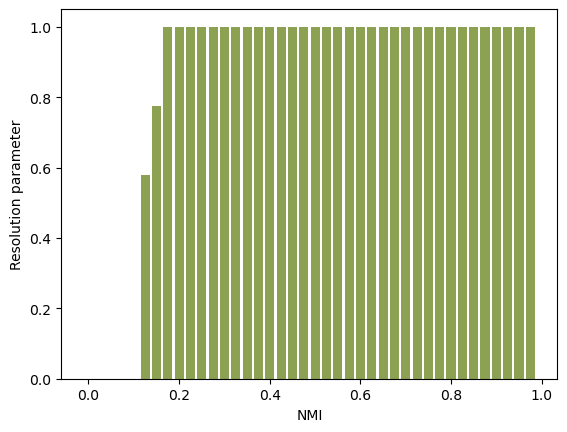

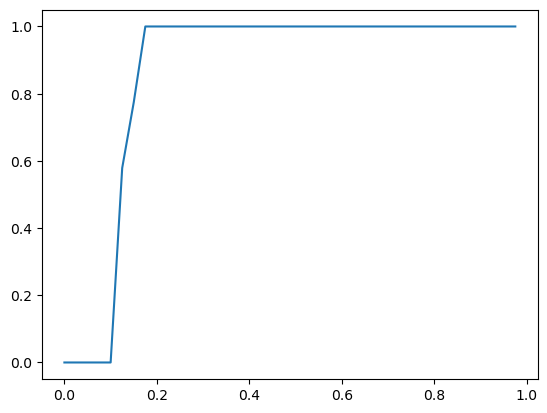

In [9]:
resolution_params = np.arange(0,1,0.025)
nmis = []
for res in resolution_params:
    #print(res)
    part = la.find_partition(H, la.RBERVertexPartition, resolution_parameter = res)
    nmi = normalized_mutual_info_score(community_labels, part.membership)
    #print(nmi)
    nmis.append(nmi)
    
    

x = np.arange(0, len(nmis))

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
cm = plt.get_cmap("tab20b")

#cm(rescale(nmis))
plt.bar(resolution_params, nmis, width=0.02, color=cm(5))
#plt.title("Resolution parameter sensitivity analysis")
plt.xlabel("NMI")
plt.ylabel("Resolution parameter")
plt.show()



plt.plot(resolution_params, nmis)
plt.show()

0.0

# NMI plot

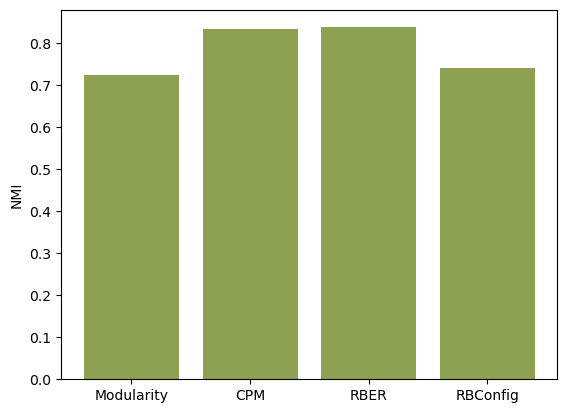

In [345]:
partitions = find_partitions(H)
nmis = nmi_partitions(community_labels, partitions)
x = np.arange(0,len(nmis), 1)


fig, ax = plt.subplots()
labs = ["Modularity", "CPM", "RBER", "RBConfig"]
ax.bar(x, nmis, color=cm(5))
ax.set_xticks(x, labs)
plt.ylabel("NMI")

#ax.bar_label(labs, label_type="center")
plt.show()

0it [00:00, ?it/s]
26it [00:03,  6.62it/s, resolution_parameter=0.147]
33it [00:05,  6.40it/s, resolution_parameter=0.112] 
0it [00:00, ?it/s]
26it [00:03,  6.61it/s, resolution_parameter=0.146]
28it [00:03,  7.24it/s, resolution_parameter=0.114] 
0it [00:00, ?it/s]
23it [00:03,  7.02it/s, resolution_parameter=0.153]
26it [00:03,  7.27it/s, resolution_parameter=0.116] 
0it [00:00, ?it/s]
30it [00:04,  6.91it/s, resolution_parameter=0.147]
33it [00:04,  7.11it/s, resolution_parameter=0.115] 
0it [00:00, ?it/s]
26it [00:03,  6.98it/s, resolution_parameter=0.153]
28it [00:03,  7.12it/s, resolution_parameter=0.116] 
0it [00:00, ?it/s]
24it [00:03,  7.01it/s, resolution_parameter=0.149]
30it [00:04,  7.16it/s, resolution_parameter=0.117] 
0it [00:00, ?it/s]
24it [00:03,  7.03it/s, resolution_parameter=0.145]
30it [00:04,  7.37it/s, resolution_parameter=0.117] 
0it [00:00, ?it/s]
25it [00:03,  7.07it/s, resolution_parameter=0.151]
26it [00:03,  7.17it/s, resolution_parameter=0.116] 
0it [00:

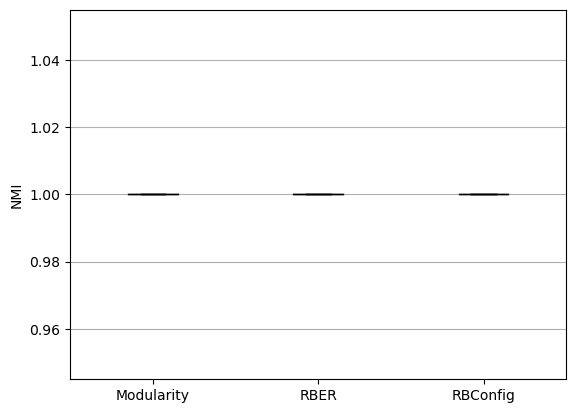

In [7]:
num = 20
nmis = nmi_confint(H, n, pmf, kernel, num)


fig, ax = plt.subplots()
labs = ["Modularity", "CPM", "RBER", "RBConfig"]
labs = ["Modularity", "RBER", "RBConfig"]
nmis = [nmis[0], nmis[2], nmis[3]]
bplot = ax.boxplot(nmis, patch_artist=True, vert=True, medianprops=dict(color="black")) #meanline=True, showmeans=True, meanprops=dict(color='white'))
#ax.set_xticks([1,2,3,4])
ax.set_xticks([1,2,3])


ax.set_xticklabels(labs)
ax.set_ylabel("NMI")

colors = ['pink', 'lightblue', 'lightgreen', "yellow"]
colors = ['pink', 'lightgreen', "yellow"]




for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.yaxis.grid(True)

plt.show()


0it [00:00, ?it/s]
26it [00:03,  6.71it/s, resolution_parameter=0.153]
30it [00:04,  6.90it/s, resolution_parameter=0.115] 
0it [00:00, ?it/s]
24it [00:03,  6.88it/s, resolution_parameter=0.152]
31it [00:04,  6.97it/s, resolution_parameter=0.114] 
0it [00:00, ?it/s]
25it [00:03,  6.71it/s, resolution_parameter=0.15] 
34it [00:04,  7.10it/s, resolution_parameter=0.114] 
0it [00:00, ?it/s]
19it [00:02,  6.87it/s, resolution_parameter=0.152]
35it [00:04,  7.25it/s, resolution_parameter=0.118] 
0it [00:00, ?it/s]
26it [00:04,  6.45it/s, resolution_parameter=0.153]
31it [00:04,  7.23it/s, resolution_parameter=0.118] 
0it [00:00, ?it/s]
24it [00:03,  6.81it/s, resolution_parameter=0.15] 
38it [00:05,  7.08it/s, resolution_parameter=0.112] 
0it [00:00, ?it/s]
24it [00:03,  6.85it/s, resolution_parameter=0.15] 
35it [00:04,  7.15it/s, resolution_parameter=0.116] 
0it [00:00, ?it/s]
27it [00:03,  7.09it/s, resolution_parameter=0.154]
30it [00:04,  7.33it/s, resolution_parameter=0.118] 
0it [00:

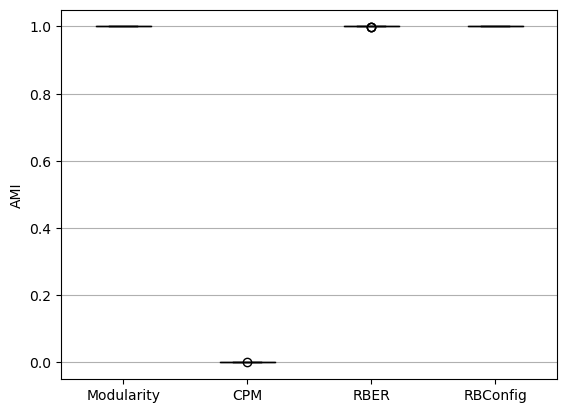

In [8]:
num = 20
#n=50
nmis = ami_confint(H, n, pmf, kernel, num)


fig, ax = plt.subplots()
labs = ["Modularity", "CPM", "RBER", "RBConfig"]
bplot = ax.boxplot(nmis, patch_artist=True, vert=True, medianprops=dict(color="black")) #meanline=True, showmeans=True, meanprops=dict(color='white'))
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(labs)
ax.set_ylabel("AMI")

colors = ['pink', 'lightblue', 'lightgreen', "yellow"]


for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

ax.yaxis.grid(True)

plt.show()

In [293]:
profile = optimiser.resolution_profile(H, la.CPMVertexPartition, resolution_range=(0,1))    
normalized_mutual_info_score(profile[10].membership, community_labels)


121it [00:00, 1187.83it/s, resolution_parameter=0.0119]


0.644922285358534

# Runtime

In [ ]:
mod_part = la.find_partition(H, la.ModularityVertexPartition)
diff = 1
optimiser = la.Optimiser()
while diff > 0:
    diff = optimiser.optimise_partition(mod_part)